In [1]:
import json
import os
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import seaborn as sns

from collections import namedtuple
from tqdm import tqdm, trange

sns.set()

In [2]:
data_prefix = "../datasets"
comment_dataset = "RC_2018-02-28.filtered"
glove_dim = 200
batch_size = 100
max_comment_len = 200

In [3]:
comment_dataset_path = os.path.join(data_prefix, comment_dataset)

In [4]:
comments_df = pd.read_json(comment_dataset_path, lines=True, chunksize=1e4).read()
controversial_comments_df = comments_df[
    (comments_df.controversiality != 0) &
    (comments_df.body != '[deleted]') &
    (comments_df.body != '[removed]')
]

Text(0.5,1,'Comment lengths')

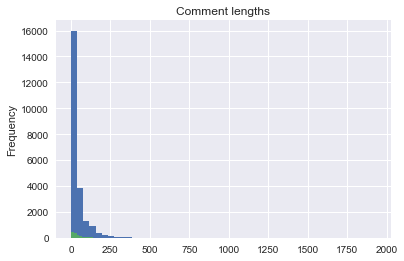

In [5]:
comment_lens = comments_df['body'].apply(nltk.tokenize.word_tokenize).str.len()
controversial_comments_lens = controversial_comments_df['body'].apply(nltk.tokenize.word_tokenize).str.len()

plt.figure()
comment_lens.plot.hist(bins=50)
controversial_comments_lens.plot.hist(bins=50)
plt.title('Comment lengths')

In [6]:
# Parse GloVe vectors

PAD_TOKEN = b"<PAD>"
PAD_ID = 0

UNK_TOKEN = b"<UNK>"
UNK_ID = 1

def get_glove(glove_dim, vocab_size=4e5):    
    initial_vocab = [PAD_TOKEN, UNK_TOKEN]
    embed_matrix = np.zeros((int(vocab_size + len(initial_vocab)), glove_dim))
    word2id = {word: idx for idx, word in enumerate(initial_vocab)}
    
    glove_path = os.path.join(data_prefix, 'glove.6B', f"glove.6B.{glove_dim}d.txt")
    
    with open(glove_path, 'r') as infile:        
        for idx, line in enumerate(tqdm(infile, total=vocab_size)):
            idx_offset = idx + len(initial_vocab)
            
            word, word_vec_raw = line.strip().split(maxsplit=1)
            word_vec = np.array([float(v) for v in word_vec_raw.split()])
            
            embed_matrix[idx_offset, :] = word_vec
            word2id[word] = idx_offset
    
    id2word = {v: k for k, v in word2id.items()}
    return embed_matrix, word2id, id2word

In [7]:
embed_matrix, word2id, id2word = get_glove(glove_dim)

100%|██████████| 400000/400000.0 [00:44<00:00, 8941.95it/s]


In [18]:
Batch = namedtuple('Batch', ['comment_tokens', 'comment_ids', 'comment_masks', 'controversialities'])

def parse_comment(comment, word2id, max_comment_len):
    comment_tokens = nltk.tokenize.word_tokenize(comment['body'])[:max_comment_len]
    if len(comment_tokens) < max_comment_len:
        comment_tokens += [PAD_TOKEN] * (max_comment_len - len(comment_tokens))
    
    comment_ids = np.array([word2id.get(token, UNK_ID) for token in comment_tokens])
    comment_mask = (comment_ids != PAD_ID).astype(np.int32)
    
    controversiality = comment['controversiality']
    return (comment_tokens, comment_ids, comment_mask, controversiality)
    
    
def create_batch(parsed_comments):
    grouped = list(zip(*parsed_comments))
    return Batch(
        comment_tokens=grouped[0],
        comment_ids=np.array(grouped[1]),
        comment_masks=np.array(grouped[2]),
        controversialities=np.array(grouped[3]).reshape(-1, 1),
    )
    

def generate_batches(dataset_path, word2id, batch_size=100, max_comment_len=200):
    """An infinite generator of batches. Just keeps looping through
    the training dataset forever, generating batches.
    """
    parsed_comments = []
    
    while True:
        with open(dataset_path, 'r') as infile:
            parsed_comments = []
            for idx, line in enumerate(infile):
                comment = json.loads(line)
                parsed_comments.append(parse_comment(comment, word2id, max_comment_len))
                
                if len(parsed_comments) == batch_size:
                    batch = create_batch(parsed_comments)
                    parsed_comments = []
                    yield batch

In [19]:
batch_generator = generate_batches(
    comment_dataset_path,
    word2id,
    batch_size,
    max_comment_len,
)

Model training time!

In [20]:
def masked_softmax(logits, mask, dim):
    exp_mask = (1 - tf.cast(mask, 'float')) * -1e30
    masked_logits = tf.add(logits, exp_mask)
    prob_dist = tf.nn.softmax(masked_logits, dim)
    return masked_logits, prob_dist

In [21]:
tf.reset_default_graph()

# Placeholders

comments = tf.placeholder(tf.int32, (None, max_comment_len))
comment_masks = tf.placeholder(tf.int32, (None, max_comment_len))
labels = tf.placeholder(tf.int32, (None, 1))

# Embedding lookup

with tf.variable_scope('embed'):
    tf_embed_matrix = tf.constant(
        embed_matrix,
        dtype=tf.float32,
        name="embed_matrix"
    )
    comment_vecs = tf.nn.embedding_lookup(tf_embed_matrix, comments)

# RNN

lstm_cell_size = 64
keep_prob = 0.75

with tf.variable_scope('lstm'):
    lstm_forward = tf.contrib.rnn.BasicLSTMCell(lstm_cell_size)
    lstm_backward = tf.contrib.rnn.BasicLSTMCell(lstm_cell_size)

    # out = tf.nn.dynamic_rnn(lstm_forward, comment_vecs, dtype=tf.float64)
    (fw_out, bw_out), _ = tf.nn.bidirectional_dynamic_rnn(
        lstm_forward,
        lstm_backward,
        comment_vecs,
        sequence_length=tf.reduce_sum(comment_masks, axis=1),
        dtype=tf.float32,
    )
    
    rnn_out = tf.concat([fw_out, bw_out], axis=2)[:, -1, :]
    rnn_out = tf.nn.dropout(rnn_out, keep_prob)
    
with tf.variable_scope('output'):
    logits = tf.contrib.layers.fully_connected(
        rnn_out,
        num_outputs=2,
        activation_fn=None,
    )
    
# Loss optimization

loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels)
)

optimizer = tf.train.AdamOptimizer().minimize(loss)

# Check accuracy

correct = tf.equal(tf.argmax(logits, 1, output_type=tf.int32), labels)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()

In [23]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

sess.run(tf.global_variables_initializer())

logdir = os.path.join('summary', str(int(time.time())))
writer = tf.summary.FileWriter(logdir, sess.graph)

for i in trange(int(1e4)):
    batch = next(batch_generator)
    _, summary = sess.run(
        [optimizer, merged],
        {
            comments: batch.comment_ids,
            comment_masks: batch.comment_masks,
            labels: batch.controversialities,
        }
    )
    writer.add_summary(summary, i)

/Users/kevinchen/code/cs224u-final-project/.env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '

  0%|          | 13/10000 [00:22<4:46:49,  1.72s/it]

KeyboardInterrupt: 